<a href="https://colab.research.google.com/github/derrickgzq/yenheranalysis/blob/main/Yenher_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing required libraries

In [1]:
install.packages('fpp3')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘warp’, ‘BH’, ‘Rcpp’, ‘distributional’, ‘progressr’, ‘slider’, ‘anytime’, ‘fable’, ‘fabletools’, ‘feasts’, ‘tsibble’, ‘tsibbledata’




In [2]:
install.packages('quantmod')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘zoo’, ‘TTR’




In [3]:
install.packages('urca')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Calling libraries

In [4]:
library(fpp3)
library(readr)
library(quantmod)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ────────────────────────────────────────────── fpp3 0.5 ──

✔ tibble      3.1.8     ✔ tsibble     1.1.3
✔ dplyr       1.1.0     ✔ tsibbledata 0.4.1
✔ tidyr       1.3.0     ✔ feasts      0.3.0
✔ lubridate   1.9.2     ✔ fable       0.3.2
✔ ggplot2     3.4.1     ✔ fabletools  0.3.2

── Conflicts ───────────────────────────────────────────────── fpp3_conflicts ──
✖ lubridate::date()    masks base::date()
✖ dplyr::filter()      masks stats::filter()
✖ tsibble::intersect() masks base::intersect()
✖ tsibble::interval()  masks lubridate::interval()
✖ dplyr::lag()         masks stats::lag()
✖ tsibble::setdiff()   masks base::setdiff()
✖ tsibble::union()     masks base::union()

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following object is masked from ‘package:tsibble’:

    index


The following objects are masked from ‘p

# Forecasting of Yenher's earnings 

Fetching dataset

In [5]:
url = 'https://raw.githubusercontent.com/derrickgzq/yenheranalysis/main/yenher%20pl%20statement.csv'
yenher = read_csv(url)

Rows: 8 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Date
dbl (2): Sales, NetProfit

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
yenher

Date,Sales,NetProfit
<chr>,<dbl>,<dbl>
3/31/2021,58786254,4937613
6/30/2021,67191499,5993644
9/30/2021,66236962,4282637
12/31/2021,71194928,5623225
3/31/2022,76088347,4912869
6/30/2022,102246197,6134572
9/30/2022,98200321,5469771
12/31/2022,78803121,5169081


Convert it to tsibble object

In [7]:
yenherdata = yenher %>% mutate(Date = yearmonth(Date)) %>% as_tsibble(index = Date)
yenherdata

Date,Sales,NetProfit
<mth>,<dbl>,<dbl>
2021 Mar,58786254,4937613
2021 Jun,67191499,5993644
2021 Sep,66236962,4282637
2021 Dec,71194928,5623225
2022 Mar,76088347,4912869
2022 Jun,102246197,6134572
2022 Sep,98200321,5469771
2022 Dec,78803121,5169081


A brief visualization on its Sales and Net Profit

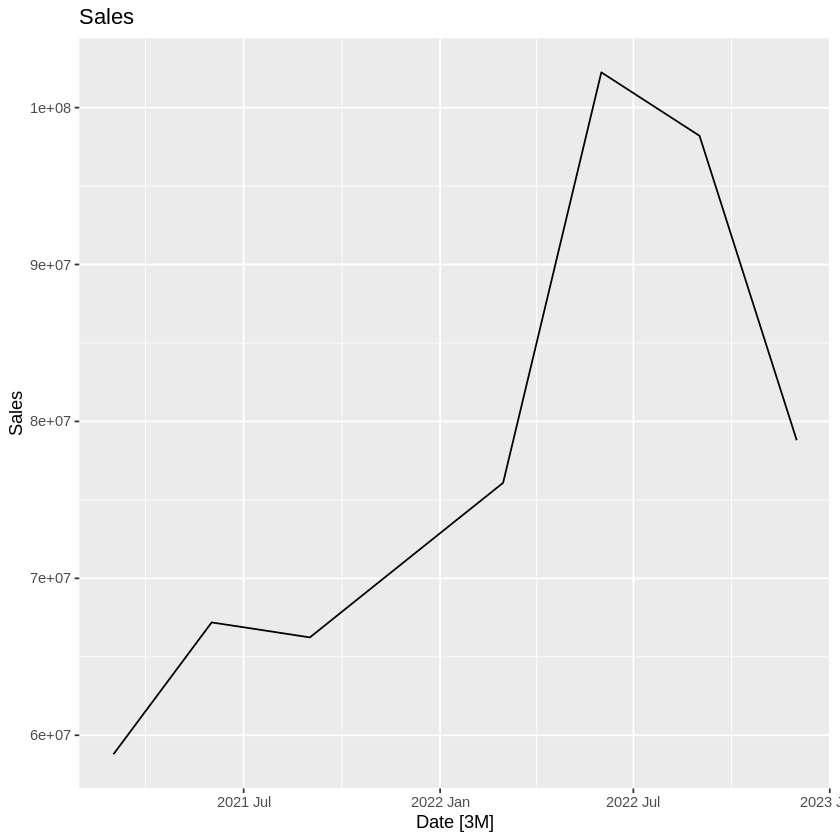

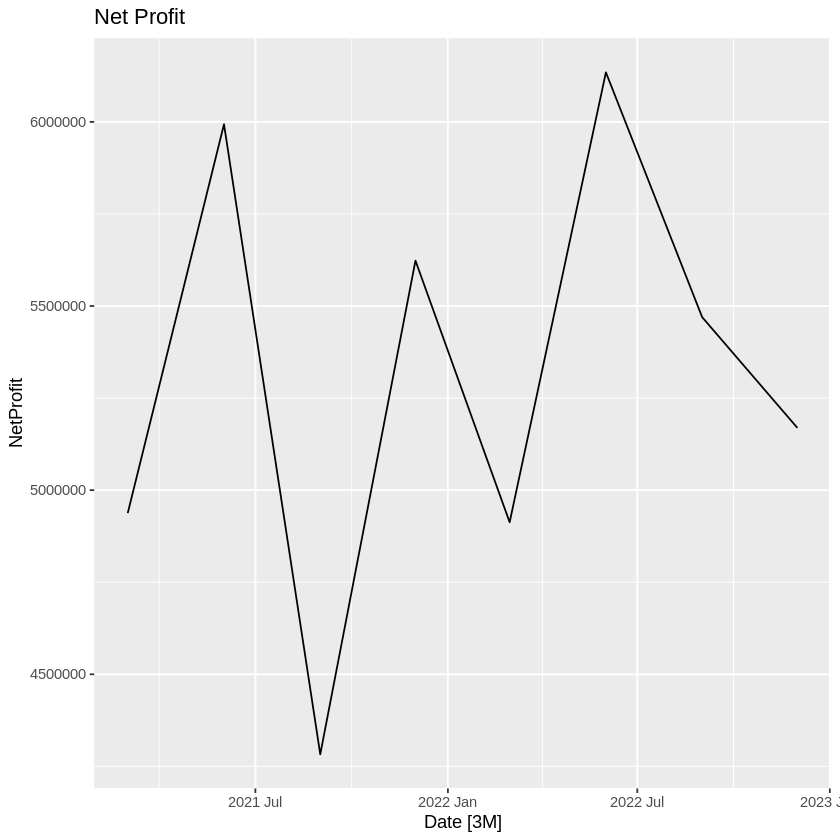

In [8]:
par(mfrow = c(1,2))
autoplot(yenherdata, Sales) +
  ggtitle('Sales')
autoplot(yenherdata, NetProfit) +
  ggtitle('Net Profit')

Modelling with all possible model techniques

In [13]:
models = yenherdata %>% model(
    mean = MEAN(Sales),
    nnaive = NAIVE(Sales),
    snnaive = SNAIVE(Sales),
    randomwalk = RW(Sales),
    rwdrift = RW(Sales ~ drift()),
    usual = TSLM(Sales ~ trend() + season(period = 4)),
    log = TSLM(log(Sales) ~ trend() + season(period = 4)),
    sqrt = TSLM(sqrt(Sales) ~ trend() + season(period = 4)),
    quartic = TSLM(Sales^(1/4) ~ trend() + season(period = 4)),
    trigo = TSLM(log(Sales) ~ trend() + fourier(period = 4, K = 2)),
    box = ARIMA(Sales, stepwise = FALSE, approximation = FALSE)
)

In [14]:
report(models)

Warning message in report.mdl_df(models):
“Model reporting is only supported for individual models, so a glance will be shown. To see the report for a specific model, use `select()` and `filter()` to identify a single model.”


.model,sigma2,r_squared,adj_r_squared,statistic,p_value,df,log_lik,AIC,AICc,BIC,CV,deviance,df.residual,rank,ar_roots,ma_roots
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<list>,<list>
mean,2.382074e+14,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NULL,NULL
nnaive,1.899501e+14,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NULL,NULL
snnaive,1.650100e+14,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NULL,NULL
randomwalk,1.899501e+14,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NULL,NULL
rwdrift,1.899501e+14,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NULL,NULL
usual,8.250502e+13,0.8515609,0.6536421,4.302577,0.1302419,5,-135.60371,260.50441,344.50441,260.98106,2.200134e+14,2.475151e+14,3,5,NULL,NULL
log,1.068805e-02,0.8763384,0.7114564,5.314941,0.1006493,5,10.72632,-32.15566,51.84434,-31.67902,2.850147e-02,3.206415e-02,3,5,NULL,NULL
sqrt,2.333116e+05,0.8644797,0.6837859,4.784225,0.1145815,5,-56.86871,103.03441,187.03441,103.51106,6.221642e+05,6.999348e+05,3,5,NULL,NULL
quartic,6.230655e+00,0.8705679,0.6979919,5.044546,0.1073728,5,-14.74612,18.78922,102.78922,19.26587,1.661508e+01,1.869196e+01,3,5,NULL,NULL


In [18]:
accuracy(models)

.model,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mean,Training,0.000000e+00,14437156,11804820,-3.2853378,15.147104,0.5136531,0.5654314,0.53718599
nnaive,Training,2.859552e+06,13076368,9830299,3.0445535,11.666233,0.4277375,0.5121361,0.01342976
snnaive,Training,2.298209e+07,25532994,22982086,24.8069751,24.806975,1.0000000,1.0000000,-0.19841631
randomwalk,Training,2.859552e+06,13076368,9830299,3.0445535,11.666233,0.4277375,0.5121361,0.01342976
rwdrift,Training,-4.257215e-09,12759873,9421792,-0.6247482,11.099172,0.4099624,0.4997406,0.01342976
usual,Training,-9.313226e-10,5562318,5263471,-0.3932224,6.919405,0.2290250,0.2178483,-0.28661660
log,Training,1.915695e+05,5018809,4463114,-0.2005125,5.681401,0.1941997,0.1965617,-0.19232319
sqrt,Training,8.749185e+04,5241103,4834115,-0.3135220,6.253817,0.2103427,0.2052679,-0.23956773
quartic,Training,1.384120e+05,5118676,4642091,-0.2597458,5.957161,0.2019874,0.2004730,-0.21580540


Based on the summary, log and trigo has the highest r2, r2 adj, lowest AIC, AICc and BIC. They are the best models.

Warning message:
“Removed 7 rows containing missing values (`geom_line()`).”


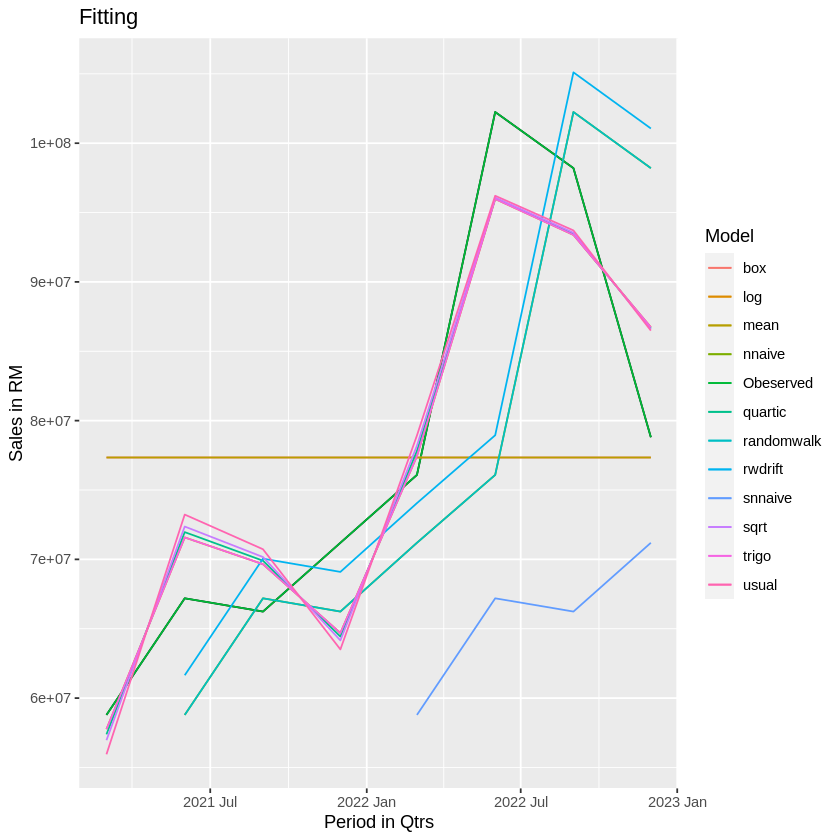

In [15]:
yenherdata %>%
  autoplot(Sales) +
  geom_line(aes(y = Sales, colour = 'Obeserved')) +
  geom_line(aes(y = .fitted, colour = .model), data = fitted(models)) +
  #autolayer(fc_trends, alpha = 0.5, level = 95) +
  xlab('Period in Qtrs') +
  ylab('Sales in RM') +
  ggtitle('Fitting') +
  guides(colour = guide_legend(title = 'Model'))

Residual plots of the best model (Model diagnostic)

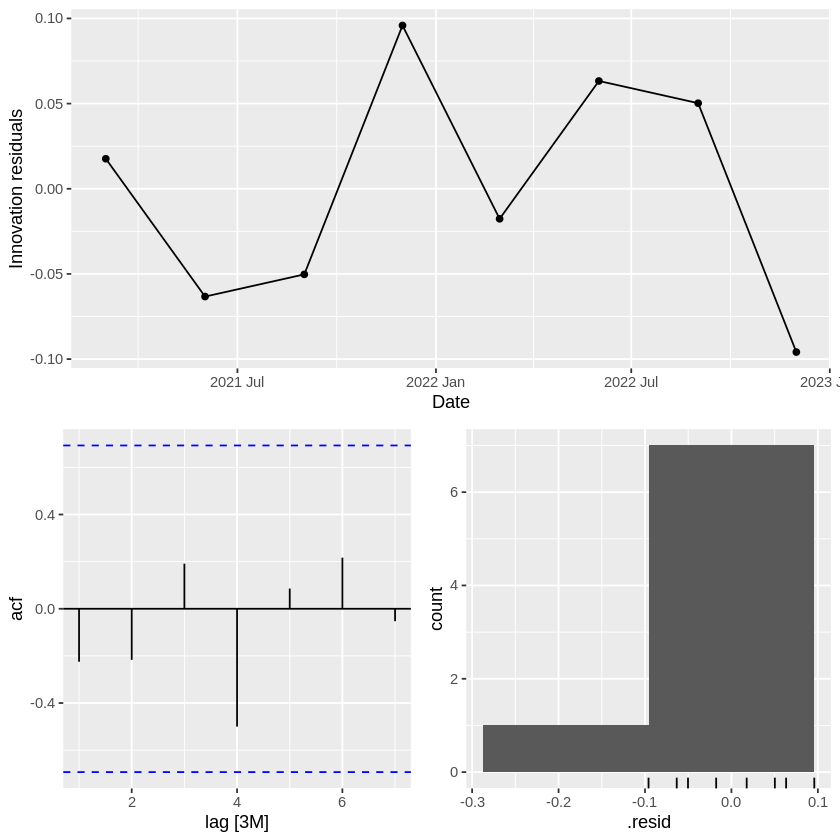

In [16]:
select(models, log) %>% gg_tsresiduals

No spike at acf, within the blue interval signifies residuals do not correlate with each other.

Forecasting

.model,Date,Sales,.mean
<chr>,<mth>,<dist>,<dbl>
log,2023 Mar,"t(N(18, 0.028))",105293780
log,2023 Jun,"t(N(19, 0.028))",130492784
log,2023 Sep,"t(N(19, 0.028))",126973300
log,2023 Dec,"t(N(19, 0.028))",117923941
log,2024 Mar,"t(N(19, 0.049))",142668083
log,2024 Jun,"t(N(19, 0.049))",176811538
log,2024 Sep,"t(N(19, 0.049))",172042804
log,2024 Dec,"t(N(19, 0.049))",159781352


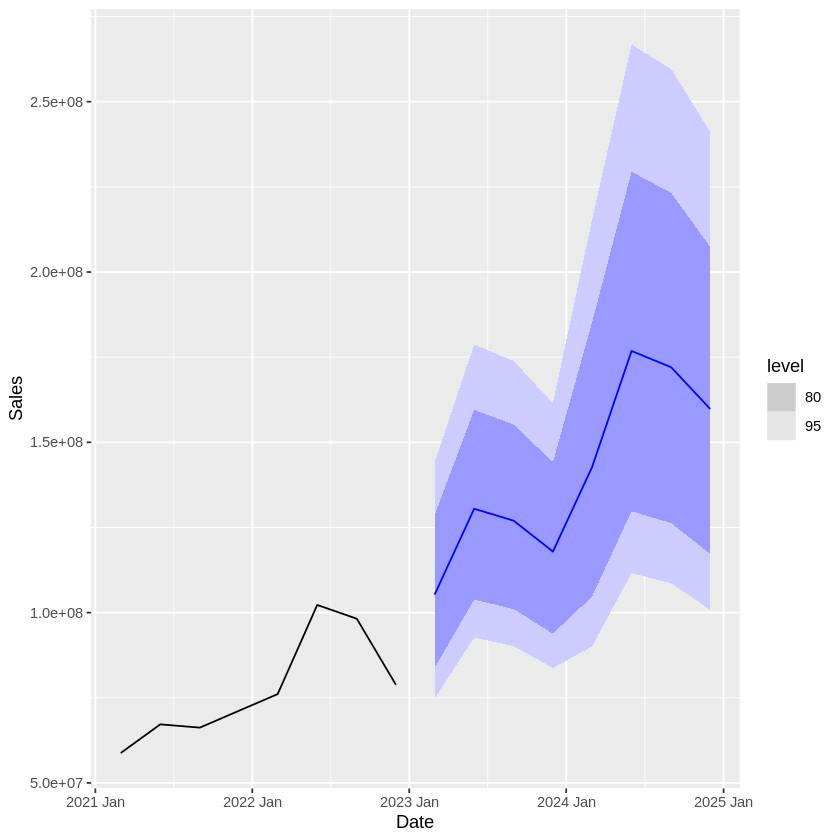

In [17]:
select(models, log) %>% forecast(h = 8) %>% autoplot(yenherdata)
select(models, log) %>% forecast(h = 8) 

In [19]:
modelsprofit = yenherdata %>% model(
    mean = MEAN(NetProfit),
    nnaive = NAIVE(NetProfit),
    snnaive = SNAIVE(NetProfit),
    randomwalk = RW(NetProfit),
    rwdrift = RW(NetProfit ~ drift()),
    usual = TSLM(NetProfit ~ trend() + season(period = 4)),
    log = TSLM(log(NetProfit) ~ trend() + season(period = 4)),
    sqrt = TSLM(sqrt(NetProfit) ~ trend() + season(period = 4)),
    quartic = TSLM(NetProfit^(1/4) ~ trend() + season(period = 4)),
    trigo = TSLM(log(NetProfit) ~ trend() + fourier(period = 4, K = 2)),
    box = ARIMA(NetProfit, stepwise = FALSE, approximation = FALSE)
)

In [20]:
report(modelsprofit)

Warning message in report.mdl_df(modelsprofit):
“Model reporting is only supported for individual models, so a glance will be shown. To see the report for a specific model, use `select()` and `filter()` to identify a single model.”


.model,sigma2,r_squared,adj_r_squared,statistic,p_value,df,log_lik,AIC,AICc,BIC,CV,deviance,df.residual,rank,ar_roots,ma_roots
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<list>,<list>
mean,3.774867e+11,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NULL,NULL
nnaive,1.393635e+12,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NULL,NULL
snnaive,4.852443e+11,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NULL,NULL
randomwalk,1.393635e+12,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NULL,NULL
rwdrift,1.393635e+12,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NULL,NULL
usual,2.426221e+11,0.7245442,0.3572698,1.972760,0.3016908,5,-112.287275,213.871534,297.87153,214.348183,6.469923e+11,7.278664e+11,3,5,NULL,NULL
log,9.922998e-03,0.6954743,0.2894401,1.712846,0.3433596,5,11.023410,-32.749836,51.25016,-32.273186,2.646133e-02,2.976899e-02,3,5,NULL,NULL
sqrt,1.224469e+04,0.7100082,0.3233525,1.836280,0.3224788,5,-45.079582,79.456147,163.45615,79.932796,3.265251e+04,3.673407e+04,3,5,NULL,NULL
quartic,1.377249e+00,0.7027331,0.3063771,1.772985,0.3329212,5,-8.708542,6.714068,90.71407,7.190717,3.672663e+00,4.131746e+00,3,5,NULL,NULL


In [21]:
accuracy(modelsprofit)

.model,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mean,Training,0.000000e+00,574718.1,489876.5,-1.2285712,9.469577,1.0844273,0.8986536,-0.6147438
nnaive,Training,3.306686e+04,1093452.0,1000739.4,-1.5725746,19.108126,2.2153118,1.7097679,-0.7793568
snnaive,Training,2.122935e+05,639532.4,451737.5,3.6778453,8.322563,1.0000000,1.0000000,-0.4824539
randomwalk,Training,3.306686e+04,1093452.0,1000739.4,-1.5725746,19.108126,2.2153118,1.7097679,-0.7793568
rwdrift,Training,-1.330501e-10,1092951.9,1005463.3,-2.1966014,19.252506,2.2257689,1.7089860,-0.7793568
usual,Training,0.000000e+00,301634.4,243710.1,-0.3736480,4.831796,0.5394950,0.4716483,-0.5367120
log,Training,9.043352e+03,306947.8,255078.5,-0.1861788,5.005334,0.5646608,0.4799565,-0.5716934
sqrt,Training,4.591759e+03,303887.2,249008.8,-0.2786117,4.911813,0.5512245,0.4751709,-0.5541994
quartic,Training,6.838800e+03,305310.4,251941.6,-0.2320018,4.956787,0.5577168,0.4773963,-0.5629689


Model 'Usual' has the highest adj r2 and lowest rmse

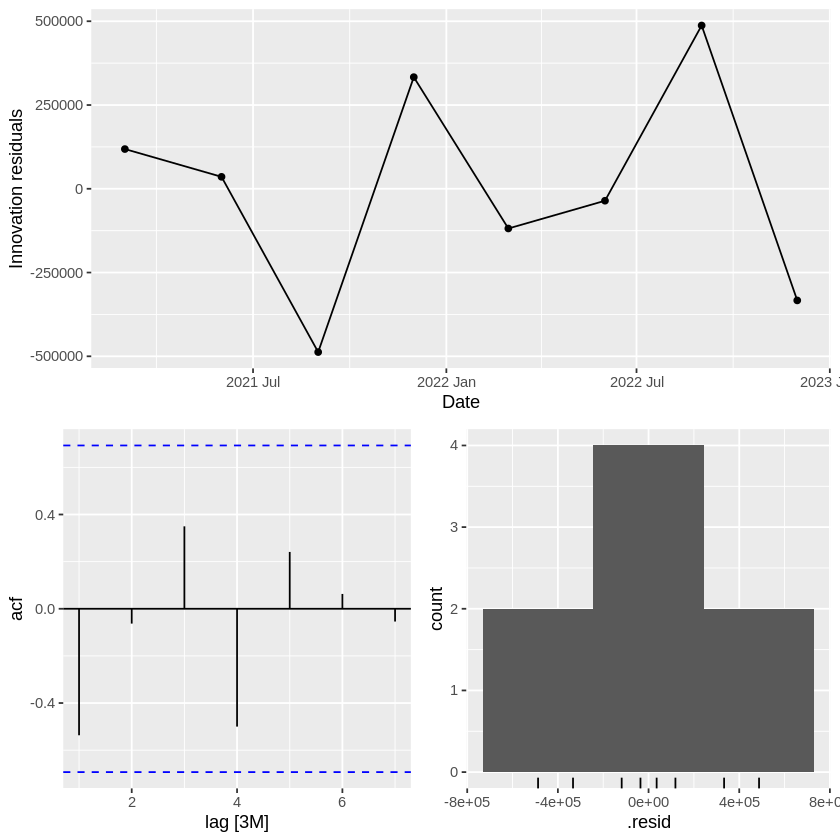

In [22]:
select(modelsprofit, usual) %>% gg_tsresiduals

Warning message:
“Removed 7 rows containing missing values (`geom_line()`).”


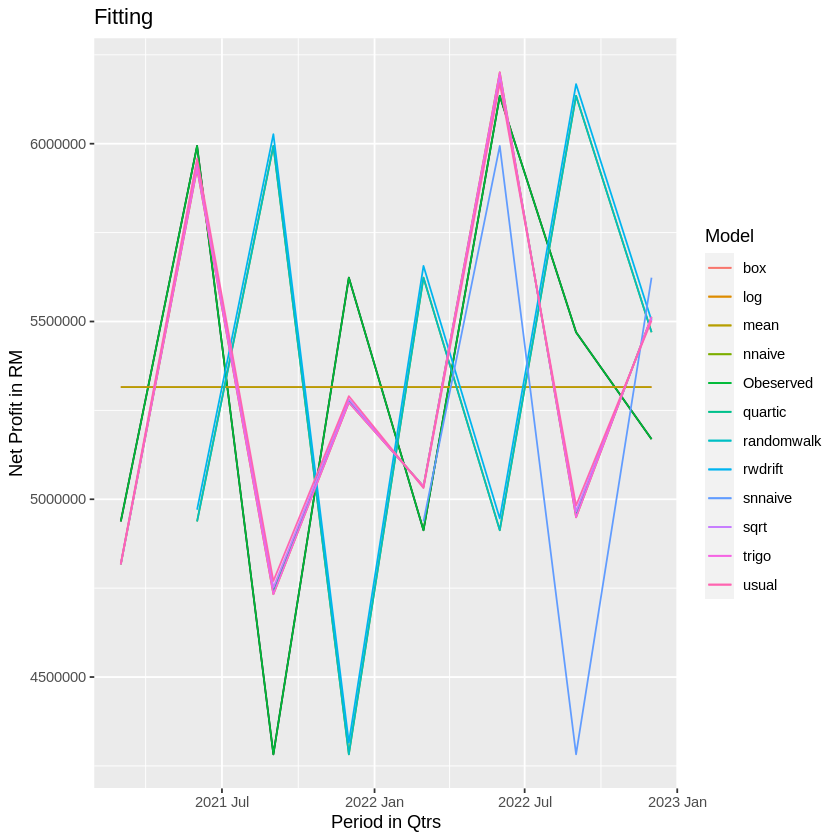

In [23]:
yenherdata %>%
  autoplot(NetProfit) +
  geom_line(aes(y = NetProfit, colour = 'Obeserved')) +
  geom_line(aes(y = .fitted, colour = .model), data = fitted(modelsprofit)) +
  #autolayer(fc_trends, alpha = 0.5, level = 95) +
  xlab('Period in Qtrs') +
  ylab('Net Profit in RM') +
  ggtitle('Fitting') +
  guides(colour = guide_legend(title = 'Model'))

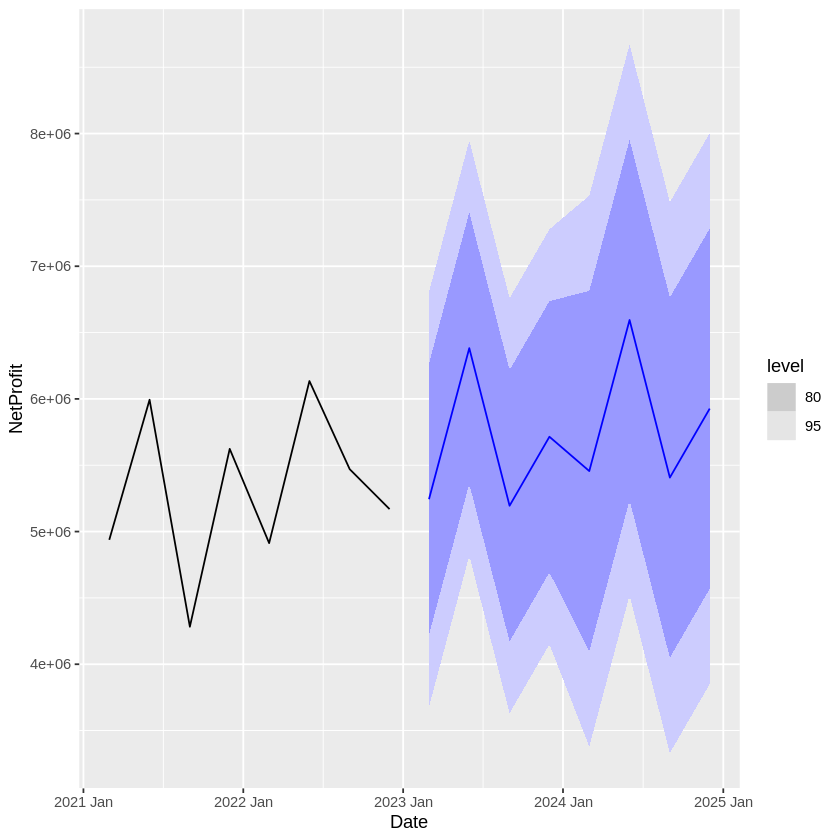

In [24]:
select(modelsprofit, usual) %>% forecast(h = 8) %>% autoplot(yenherdata)

# Forecasting Yenher's financial indicators

In [25]:
url = 'https://raw.githubusercontent.com/derrickgzq/yenheranalysis/main/yenher%20balance%20sheet.csv'
yenherfin = read_csv(url)

New names:
• `Lease Liabilities` -> `Lease Liabilities...26`
• `Lease Liabilities` -> `Lease Liabilities...29`
Rows: 8 Columns: 54
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (9): Trade Receivables/Revenue Ratio, Trade Payables/Revenue Ratio, ROE...
num (45): Sales, Cost of Sales, Gross Income, Other Income, SG&A Expense, Ot...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [26]:
yenherfin

Sales,Cost of Sales,Gross Income,Other Income,SG&A Expense,Other Expense,General & Admin Expense,Research & Development,Depr. & Amort.,Operating Income,⋯,ROE,ROA,ROIC,Debt/Equity,Debt/Assets,Debt/Cash,Total Cash,Total Debt,SG&A/Revenue Ratio,Free Cash Flow
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
58786254,45882525,12903729,273153,2372152,21300,4098160,50075,471021,6635195,⋯,0.0369,0.0296,3.6307,0.0099,0.0079,0.0931,14165716,1318607,0.04035215,6656345
67191499,53953679,13237820,99641,1962340,52979,3317033,40970,964858,7964139,⋯,0.0465,0.0363,4.3684,0.0629,0.0491,1.2219,6633120,8105204,0.02920518,12932475
66236962,54382708,11854254,281035,2437844,19218,3983528,87502,1481679,5607197,⋯,0.0227,0.0194,2.2392,0.0153,0.0131,0.0443,65238639,2889295,0.03680489,-54043698
71194928,57328401,13866527,352225,2781820,8717,3690273,127651,2014090,7610291,⋯,0.0290,0.0253,2.8590,0.0124,0.0108,0.0359,66820990,2397758,0.03907329,567669
76088347,64109025,11979322,337144,2348565,27072,3313638,172982,522274,6454209,⋯,0.0247,0.0214,2.4068,0.0261,0.0227,0.0863,60190972,5195383,0.03086629,1804343
102246197,87339686,14906511,585211,3591154,22400,3694643,108339,1068752,8075186,⋯,0.0306,0.0253,2.8951,0.0612,0.0507,0.2342,52413441,12274328,0.03512262,6331563
98200321,84028934,14171387,596514,3566831,15570,3689896,175688,1620195,7319916,⋯,0.0272,0.0234,2.6471,0.0236,0.0204,0.0812,58643710,4761580,0.03632199,6531147
78803121,66284717,12518404,249915,2818870,22385,3089165,76362,2199900,6761537,⋯,0.0241,0.0212,2.3643,0.0121,0.0107,0.0407,63918105,2600592,0.03577105,2222033


In [27]:
cor(yenherfin)

Warning message in cor(yenherfin):
“the standard deviation is zero”


,Sales,Cost of Sales,Gross Income,Other Income,SG&A Expense,Other Expense,General & Admin Expense,Research & Development,Depr. & Amort.,Operating Income,⋯,ROE,ROA,ROIC,Debt/Equity,Debt/Assets,Debt/Cash,Total Cash,Total Debt,SG&A/Revenue Ratio,Free Cash Flow
Sales,1.00000000,0.998553939,0.67980773,0.85461741,0.89885304,-0.22652620,-0.19582814,0.569764646,0.22365446,0.46689420,⋯,-0.29460674,-0.28170321,-0.33577928,0.39593146,0.43921585,-0.16801320,0.41628583,0.63090742,-0.1191386292,0.27622272
Cost of Sales,0.99855394,1.000000000,0.63939834,0.84815840,0.88943352,-0.22596474,-0.21464053,0.585330823,0.22371063,0.42716672,⋯,-0.32902659,-0.31798343,-0.37091421,0.37997426,0.42435160,-0.18488296,0.44045631,0.61918380,-0.1366281396,0.25106475
Gross Income,0.67980773,0.639398338,1.00000000,0.65223114,0.72181799,-0.15718491,0.12737981,0.163733761,0.14686354,0.85015724,⋯,0.27509776,0.30899468,0.25767595,0.47903760,0.49269860,0.11923822,-0.05495606,0.57638532,0.1599540627,0.52553888
Other Income,0.85461741,0.848158400,0.65223114,1.00000000,0.93185364,-0.59037222,0.25795710,0.688633784,0.10619748,0.24920482,⋯,-0.42932185,-0.41518181,-0.44259270,0.07113097,0.11754035,-0.50098223,0.48371778,0.35570944,0.2834137304,0.11020512
SG&A Expense,0.89885304,0.889433523,0.72181799,0.93185364,1.00000000,-0.56935270,0.10670490,0.517182180,0.37196880,0.34974324,⋯,-0.40980606,-0.38863443,-0.42655294,0.07619019,0.11771455,-0.45143285,0.50015030,0.34737098,0.3264214133,0.16028214
Other Expense,-0.22652620,-0.225964745,-0.15718491,-0.59037222,-0.56935270,1.00000000,-0.43289680,-0.495456714,-0.43246466,0.26914521,⋯,0.72352210,0.69251241,0.69085412,0.68534035,0.65354989,0.92046168,-0.71253599,0.43425906,-0.8050808156,0.27657866
General & Admin Expense,-0.19582814,-0.214640532,0.12737981,0.25795710,0.10670490,-0.43289680,1.00000000,-0.096988690,-0.26394460,-0.25864946,⋯,0.01026812,-0.01414737,0.04578789,-0.25969250,-0.26413859,-0.31718892,-0.12211247,-0.21622029,0.6812006400,-0.41141208
Research & Development,0.56976465,0.585330823,0.16373376,0.68863378,0.51718218,-0.49545671,-0.09698869,1.000000000,0.10026535,-0.02498672,⋯,-0.60055157,-0.56978525,-0.61047422,-0.15924016,-0.11385616,-0.49437119,0.66971551,0.05407537,-0.0525864079,0.03994355
Depr. & Amort.,0.22365446,0.223710633,0.14686354,0.10619748,0.37196880,-0.43246466,-0.26394460,0.100265347,1.00000000,0.06016251,⋯,-0.43060279,-0.38791001,-0.43277837,-0.32561209,-0.31856876,-0.27197602,0.60604301,-0.26124917,0.2971529050,-0.18850938
Operating Income,0.46689420,0.427166718,0.85015724,0.24920482,0.34974324,0.26914521,-0.25864946,-0.024986721,0.06016251,1.00000000,⋯,0.57247796,0.61269023,0.54561502,0.68114967,0.67864684,0.51275065,-0.30062375,0.64737095,-0.2301839660,0.74680421
